In [1]:
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

# Define the dropdown widgets for input
start_year = widgets.Dropdown(
    options=[str(year) for year in range(2000, 2025)],
    description='Start Year:'
)
start_month = widgets.Dropdown(
    options=[f"{month:02d}" for month in range(1, 13)],
    description='Start Month:'
)
start_day = widgets.Dropdown(
    options=[f"{day:02d}" for day in range(1, 32)],
    description='Start Day:'
)

end_year = widgets.Dropdown(
    options=[str(year) for year in range(2000, 2025)],
    description='End Year:'
)
end_month = widgets.Dropdown(
    options=[f"{month:02d}" for month in range(1, 13)],
    description='End Month:'
)
end_day = widgets.Dropdown(
    options=[f"{day:02d}" for day in range(1, 32)],
    description='End Day:'
)

aoi_input = widgets.Text(
    description="AOI (bbox):",
    placeholder="Enter bbox as minX,minY,maxX,maxY"
)

# Display the widgets
display(start_year, start_month, start_day, end_year, end_month, end_day, aoi_input)

# Function to retrieve input from widgets
# Function to retrieve input from widgets
def get_inputs():
    try:
        # Validate dates
        start_date = datetime(
            int(start_year.value), int(start_month.value), int(start_day.value)
        ).strftime('%Y-%m-%d')
        end_date = datetime(
            int(end_year.value), int(end_month.value), int(end_day.value)
        ).strftime('%Y-%m-%d')
        
        # Validate AOI input
        try:
            aoi = [float(coord) for coord in aoi_input.value.split(",")]
            if len(aoi) != 4:
                print("Invalid AOI format. Please enter as minX,minY,maxX,maxY.")
                return None, None, None
            # Validate bounding box coordinates
            if not (aoi[0] < aoi[2] and aoi[1] < aoi[3]):
                print("Invalid AOI: Ensure minX < maxX and minY < maxY.")
                return None, None, None
        except ValueError as e:
            print(f"Invalid AOI input. Error: {e}")
            return None, None, None
        
        return start_date, end_date, aoi
    except ValueError as e:
        print(f"Input error: {e}")
        return None, None, None

# List satellite collections with metadata
satellite_sources = {
    "Sentinel-2": {
        "Temporal Extent": "2015-Present",
        "Spatial Resolution": "10m (Visible, NIR), 20m (Red Edge, SWIR), 60m (Coastal, Aerosols)",
        "Return Time": "5 days",
        "Bands": "B02 (Blue), B03 (Green), B04 (Red), B08 (NIR), others"
    },
    "Landsat 8-9": {
        "Temporal Extent": "2013-Present",
        "Spatial Resolution": "30m",
        "Return Time": "16 days",
        "Bands": "B1 (Coastal), B2 (Blue), B3 (Green), B4 (Red), B5 (NIR), others"
    },

    "NAIP (US only)": {
        "Temporal Extent": "2010-Present (varies by state)",
        "Spatial Resolution": "0.3m-1m",
        "Return Time": "Every 2-3 years",
        "Bands": "R, G, B, NIR (varies)"
    },
}


# Print satellite source options and metadata
print("\nAvailable Satellite Data Sources for Vegetation Analysis:\n")
for source, metadata in satellite_sources.items():
    print(f"{source}:")
    for key, value in metadata.items():
        print(f"  {key}: {value}")
    print()

Dropdown(description='Start Year:', options=('2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '…

Dropdown(description='Start Month:', options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'…

Dropdown(description='Start Day:', options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', …

Dropdown(description='End Year:', options=('2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '20…

Dropdown(description='End Month:', options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', …

Dropdown(description='End Day:', options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '1…

Text(value='', description='AOI (bbox):', placeholder='Enter bbox as minX,minY,maxX,maxY')


Available Satellite Data Sources for Vegetation Analysis:

Sentinel-2:
  Temporal Extent: 2015-Present
  Spatial Resolution: 10m (Visible, NIR), 20m (Red Edge, SWIR), 60m (Coastal, Aerosols)
  Return Time: 5 days
  Bands: B02 (Blue), B03 (Green), B04 (Red), B08 (NIR), others

Landsat 8-9:
  Temporal Extent: 2013-Present
  Spatial Resolution: 30m
  Return Time: 16 days
  Bands: B1 (Coastal), B2 (Blue), B3 (Green), B4 (Red), B5 (NIR), others

NAIP (US only):
  Temporal Extent: 2010-Present (varies by state)
  Spatial Resolution: 0.3m-1m
  Return Time: Every 2-3 years
  Bands: R, G, B, NIR (varies)



In [2]:
import ipywidgets as widgets
from shapely.geometry import box
import geopandas as gpd
import pystac_client

# Function to query satellite collections using the previously set widget values
def query_collections():
    # Retrieve the values from the widgets
    start_date = f"{start_year.value}-{start_month.value}-{start_day.value}"
    end_date = f"{end_year.value}-{end_month.value}-{end_day.value}"
    aoi = [float(coord) for coord in aoi_input.value.split(",")]

    # Validate AOI format
    if len(aoi) != 4:
        raise ValueError("Invalid AOI format. Please enter as minX,minY,maxX,maxY.")
    
    # Ensure AOI is a valid bounding box
    try:
        aoi_geometry = box(*aoi)  # This will raise an error if coordinates are invalid
        bbox = aoi_geometry.bounds  # Get bounding box coordinates
    except Exception as e:
        raise ValueError(f"Error creating bounding box from AOI: {e}")

    # MPC STAC API endpoint
    stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(stac_url)

    # Satellite collections and their STAC IDs
    collections = {
        "Sentinel-2": "sentinel-2-l2a",
        "Landsat 8-9": "landsat-8-c2-l2",
        "NAIP (US only)": "naip",
    }
    
    # Results list to store collection data
    all_results = []

    # Query each collection
    for name, collection_id in collections.items():
        collection_box = widgets.VBox()  # Create a VBox for each collection's widget box
        try:
            search = catalog.search(
                collections=[collection_id],
                datetime=f"{start_date}/{end_date}",
                bbox=bbox
            )
            items = list(search.get_items())
            if items:
                # Count images
                num_images = len(items)
                
                # Initialize default values for cloud coverage and dates
                avg_cloud_coverage = "N/A"
                non_cloudy_images = 0
                non_cloudy_dates = []

                # If not NAIP, calculate cloud coverage and filter non-cloudy images
                if name != "NAIP (US only)":
                    cloud_coverages = [
                        float(item.properties.get("eo:cloud_cover", 0)) for item in items if "eo:cloud_cover" in item.properties
                    ]
                    avg_cloud_coverage = sum(cloud_coverages) / len(cloud_coverages) if cloud_coverages else "N/A"
                    
                    # Filter non-cloudy images (less than 5% cloud cover)
                    non_cloudy_items = [
                        item for item in items 
                        if float(item.properties.get("eo:cloud_cover", 100)) < 5
                    ]
                    non_cloudy_images = len(non_cloudy_items)

                # Add the results as text to a text widget
                results_text = (
                    f"**Collection:** {name}\n"
                    f"**Number of Images:** {num_images}\n"
                    f"**Average Cloud Coverage:** {avg_cloud_coverage}\n"
                    f"**Non-Cloudy Images (<5% Cloud):** {non_cloudy_images}\n"
                )
                results_widget = widgets.Textarea(
                    value=results_text,
                    layout=widgets.Layout(width="90%", height="100px"),
                    disabled=True
                )

                # For non-NAIP collections, display the results without the non-cloudy date list
                collection_box.children = [results_widget]

            else:
                # Handle no items case
                results_text = (
                    f"**Collection:** {name}\n"
                    f"**Number of Images:** 0\n"
                    f"**Average Cloud Coverage:** N/A\n"
                    f"**Non-Cloudy Images (<5% Cloud):** 0\n"
                )
                results_widget = widgets.Textarea(
                    value=results_text,
                    layout=widgets.Layout(width="90%", height="100px"),
                    disabled=True
                )

                # Add the results widget to the collection's VBox
                collection_box.children = [results_widget]

            # Add the collection's widget box to the main results list
            all_results.append(collection_box)

        except Exception as e:
            # Handle error case
            error_text = f"**Collection:** {name}\nError retrieving data: {e}\n"
            error_widget = widgets.Textarea(
                value=error_text,
                layout=widgets.Layout(width="90%", height="100px"),
                disabled=True
            )
            collection_box.children = [error_widget]
            all_results.append(collection_box)

    # Display all collection widgets
    display(*all_results)

# Call the query function immediately after defining it to load the results with widget inputs
query_collections()

/home/monyy3m/miniconda3/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [3]:
# Additional Code to Create Non-Cloudy Collections
from pystac_client import Client

# MPC STAC API endpoint
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(stac_url)

# Define bounding box and date range (replace these with actual widget values or set manually)
bbox = [-78, 36, -77, 37]  # Replace with actual AOI values
start_date = "2020-01-01"
end_date = "2020-12-31"

# Collections and their STAC IDs
collections = {
    "Sentinel-2": "sentinel-2-l2a",
    "Landsat 8-9": "landsat-8-c2-l2",
}

# Initialize dictionaries to store filtered collections
non_cloudy_collections = {
    "Sentinel-2": [],
    "Landsat 8-9": [],
}

# Filter each collection for non-cloudy images
for name, collection_id in collections.items():
    try:
        search = catalog.search(
            collections=[collection_id],
            datetime=f"{start_date}/{end_date}",
            bbox=bbox,
        )
        items = list(search.get_items())
        
        # Filter for non-cloudy images (less than 5% cloud cover)
        if name != "NAIP (US only)":
            non_cloudy_items = [
                item for item in items 
                if float(item.properties.get("eo:cloud_cover", 100)) < 5
            ]
            non_cloudy_collections[name] = non_cloudy_items

        print(f"{name}: {len(non_cloudy_collections[name])} non-cloudy images added.")
    
    except Exception as e:
        print(f"Error processing collection {name}: {e}")

# Now you have non_cloudy_collections with filtered data for Sentinel-2 and Landsat

Sentinel-2: 249 non-cloudy images added.
Landsat 8-9: 26 non-cloudy images added.


In [4]:
# Loop through each collection (Sentinel-2 and Landsat) and print relevant information
for name, collection_items in non_cloudy_collections.items():
    print(f"Collection: {name}")
    print(f"Total number of non-cloudy images: {len(collection_items)}")
    
    for item in collection_items:
        # Extract metadata for each image item
        cloud_cover = item.properties.get("eo:cloud_cover", "Not Available")
        start_datetime = item.properties.get("datetime", "Not Available")
        item_id = item.id
        
        # Print image metadata
        print(f"  - Image ID: {item_id}")
        print(f"    Cloud Cover: {cloud_cover}%")
        print(f"    Start Date: {start_datetime}")
        
        # Get the dimensions (if available) - can be extracted from the item's assets
        if "B04" in item.assets:  # You can choose any asset band available in the image
            asset = item.assets["B04"]
            print(f"    Asset (B04) Available: {asset.href}")
        
        print()

Collection: Sentinel-2
Total number of non-cloudy images: 249
  - Image ID: S2A_MSIL2A_20201229T160651_R097_T18STG_20201230T010133
    Cloud Cover: 1.557387%
    Start Date: 2020-12-29T16:06:51.024000Z
    Asset (B04) Available: https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/S/TG/2020/12/29/S2A_MSIL2A_20201229T160651_N0212_R097_T18STG_20201230T010133.SAFE/GRANULE/L2A_T18STG_A028837_20201229T160853/IMG_DATA/R10m/T18STG_20201229T160651_B04_10m.tif

  - Image ID: S2A_MSIL2A_20201229T160651_R097_T18STF_20201230T010254
    Cloud Cover: 1.832713%
    Start Date: 2020-12-29T16:06:51.024000Z
    Asset (B04) Available: https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/S/TF/2020/12/29/S2A_MSIL2A_20201229T160651_N0212_R097_T18STF_20201230T010254.SAFE/GRANULE/L2A_T18STF_A028837_20201229T160853/IMG_DATA/R10m/T18STF_20201229T160651_B04_10m.tif

  - Image ID: S2A_MSIL2A_20201229T160651_R097_T18STE_20201230T010929
    Cloud Cover: 0.102973%
    Start Date: 2020-12-29T16:06:51.


Processing Sentinel-2 imagery...


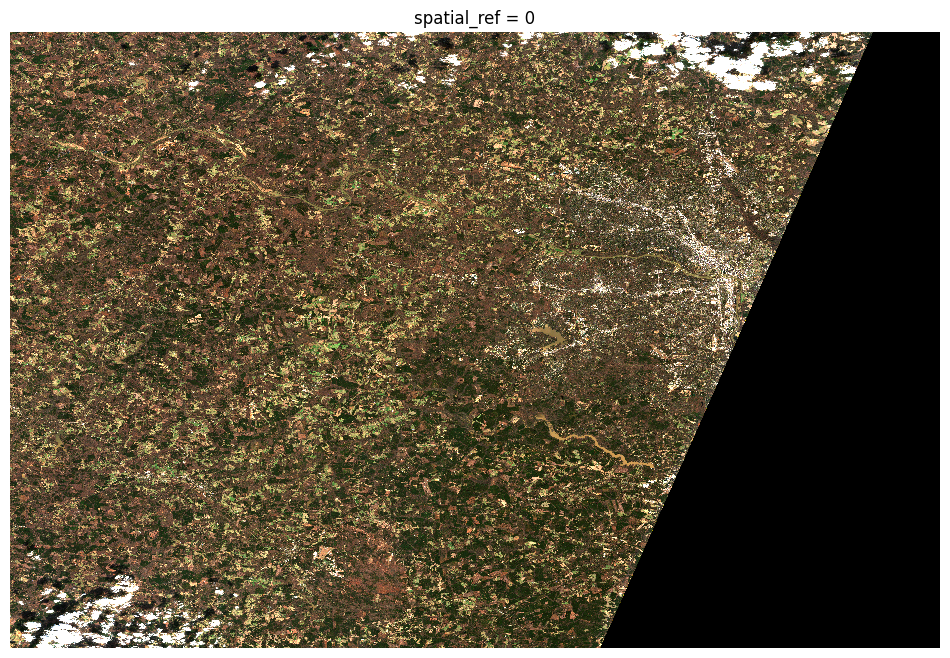

Creating mosaic from 3 images...


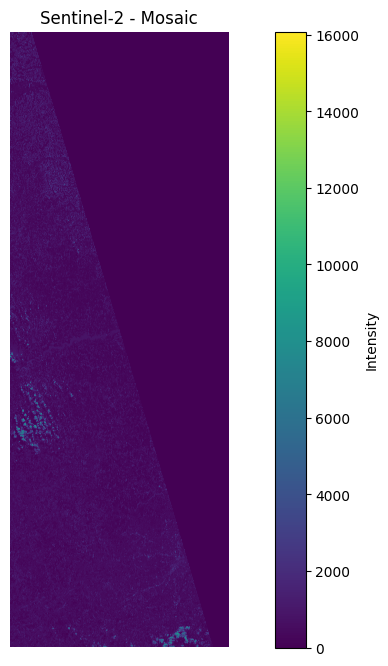


Processing Landsat 8-9 imagery...


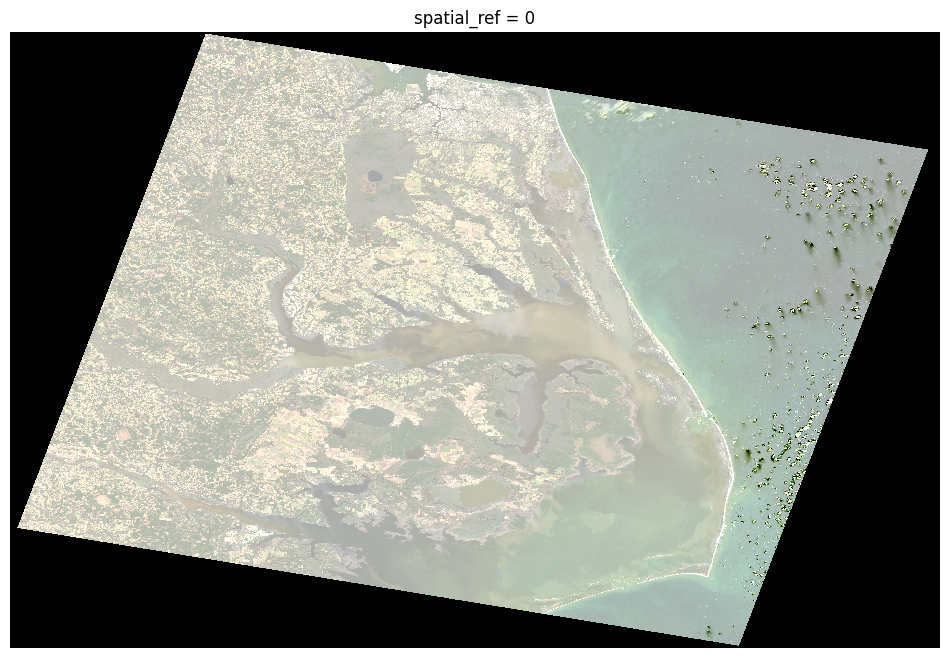

Creating mosaic from 3 images...


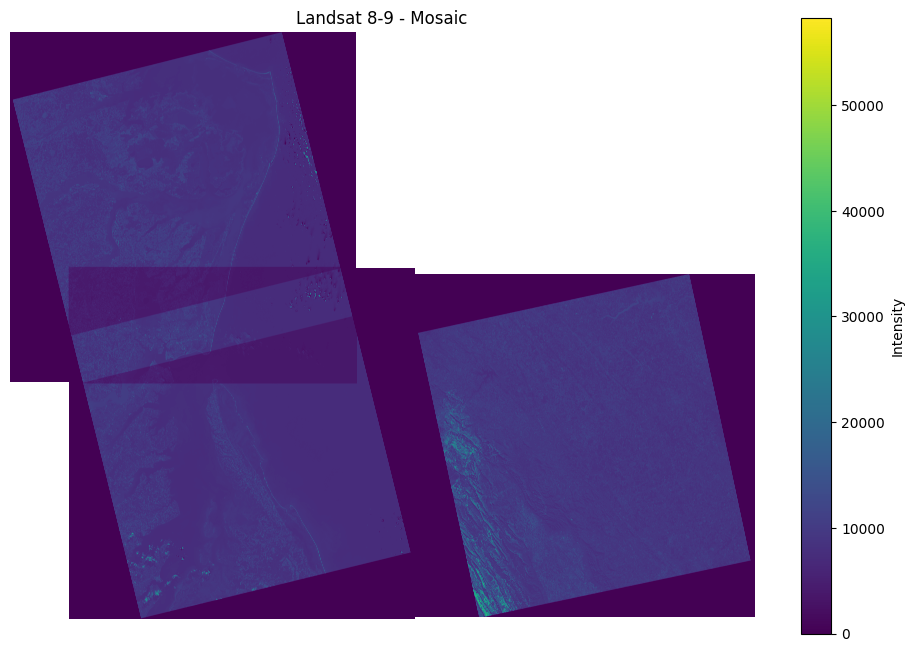

In [5]:
import planetary_computer
import rioxarray
import matplotlib.pyplot as plt
import xarray as xr
from IPython.display import display

def display_collection_imagery(collection_items, collection_name):
    print(f"\nProcessing {collection_name} imagery...")
    
    # Band configurations for each collection
    band_configs = {
        "Sentinel-2": {"red": "B04", "green": "B03", "blue": "B02"},
        "Landsat 8-9": {"red": "SR_B4", "green": "SR_B3", "blue": "SR_B2"},
        "NAIP (US only)": {"red": "R", "green": "G", "blue": "B"}
    }
    
    if not collection_items:
        print(f"No images available for {collection_name}")
        return
        
    # Display single image
    item = collection_items[0]
    signed_item = planetary_computer.sign(item)
    bands = band_configs[collection_name]
    
    # Create RGB composite based on collection type
    if collection_name == "NAIP (US only)":
        # NAIP has all bands in one asset
        data = rioxarray.open_rasterio(signed_item.assets["image"].href)
        rgb_composite = data
    else:
        # For Sentinel and Landsat, combine individual bands
        rgb_layers = []
        for band in bands.values():
            data = rioxarray.open_rasterio(signed_item.assets[band].href)
            rgb_layers.append(data)
        rgb_composite = xr.concat(rgb_layers, dim='band')
        
    # Display single image
        plt.figure(figsize=(12, 8))
        plt.title(f"{collection_name} - Single Image ({item.properties['datetime'][:10]})")
        rgb_composite.plot.imshow(robust=True)
        plt.axis('off')
        plt.show()
    
    # Create mosaic if multiple images exist
    if len(collection_items) > 1:
        print(f"Creating mosaic from {min(3, len(collection_items))} images...")
        mosaic_layers = []
        for item in collection_items[:3]:  # Use up to 3 images for mosaic
            signed_item = planetary_computer.sign(item)
            data = rioxarray.open_rasterio(signed_item.assets[bands['red']].href)
            mosaic_layers.append(data)
            
        mosaic = xr.concat(mosaic_layers, dim='time').mean(dim='time')

         # Reshape mosaic data for visualization
        mosaic_data = mosaic.values.squeeze()  # Take the first band
        
        plt.figure(figsize=(12, 8))
        plt.title(f"{collection_name} - Mosaic")
        plt.imshow(mosaic.values[0], cmap='viridis')
        plt.colorbar(label='Intensity')
        plt.axis('off')
        plt.show()

# Process and display imagery for each collection
for name, items in non_cloudy_collections.items():
    display_collection_imagery(items, name)